**参考文献**
**Convolution Transformer Mixer for Hyperspectral Image Classification**

**CTMixer**

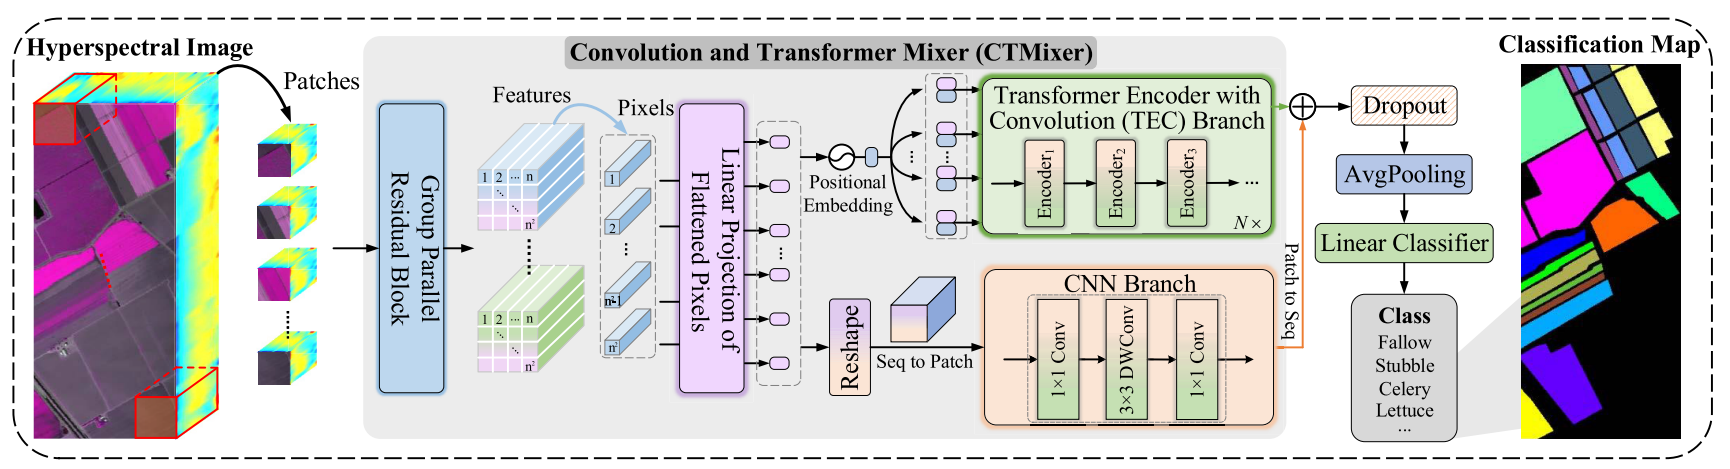

In [1]:
!pip install torchinfo
!pip install embeddings
!pip install transformers==3.4.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 37.9 MB/s 
     |████████████████████████████████| 2.9 MB 54.4 MB/s 
     |████████████████████████████████| 880 kB 64.6 MB/s 
     |████████████████████████████████| 1.3 MB 56.1 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=f09c3aa8a28e4248ff6bf7e7cf307cd58ebb658d68f8d34dd2b8bf11c92695bb
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses


In [2]:
# Torch
import math
import torch
import numpy as np
import torch.nn as nn
from torch.nn import init
from torchinfo import summary
import torch.nn.functional as F

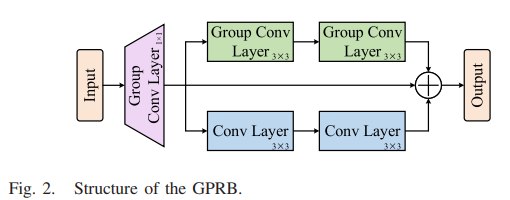

In [3]:
class Pooling(nn.Module):
  def __init__(self,pool:str='mean'):
    super().__init__()
    if pool not in ['mean','cls']:
      raise ValueError("pool must be one of {mean, cls}")
    self.pool_fn = self.mean_pool if pool == 'mean' else self.cls_pool
  
  def mean_pool(self,x:torch.Tensor) -> torch.Tensor:
    return x.mean(dim=1)
  def cls_pool(self,x:torch.Tensor) -> torch.Tensor:
    return x[:,0]

  def forward(self,x:torch.Tensor) -> torch.Tensor:
    return self.pool_fn(x)

class Classifier(nn.Module):
  def __init__(self,dim:int,num_classes:int):
    super().__init__()
    self.model = nn.Sequential(
        nn.LayerNorm(dim),
        nn.Linear(in_features=dim,out_features=num_classes)
    )
  def forward(self,x:torch.Tensor) -> torch.Tensor:
    return self.model(x)

#a branch of the GPRB(this branch is ordinary conv)
class Res2(nn.Module):
  def __init__(self,in_channels,inter_channels,kernel_size,padding=0):
    super(Res2,self).__init__()
    self.conv1 = nn.Conv2d(in_channels,inter_channels,kernel_size=kernel_size,padding=padding)
    self.bn1 = nn.BatchNorm2d(inter_channels)
    self.conv2 = nn.Conv2d(inter_channels,in_channels,kernel_size=kernel_size,padding=padding)
    self.bn2 = nn.BatchNorm2d(in_channels)
  def forward(self,x):
    x = F.relu(self.bn1(self.conv1(x)))
    x = self.bn2(self.conv2(x))
    return x

#Structure of the GPRB( conv(x) + gconv(x) + x )
class Res(nn.Module):
  def __init__(self,in_channels,kernel_size,padding,groups_s):
    super(Res,self).__init__()
    self.conv1 = nn.Conv2d(in_channels,in_channels,kernel_size=kernel_size,padding=padding,groups=groups_s)
    self.bn1 = nn.BatchNorm2d(in_channels)
    self.conv2 = nn.Conv2d(in_channels,in_channels,kernel_size=kernel_size,padding=padding,groups=groups_s)
    self.bn2 = nn.BatchNorm2d(in_channels)
    self.res2 = Res2(in_channels,32,kernel_size=kernel_size,padding=padding)
  def forward(self,x):
    Y = F.relu(self.bn1(self.conv1(x)))
    Y = self.bn2(self.conv2(Y))
    Z = self.res2(x)
    return F.relu(x+Y+Z)

In [4]:
#realize CTMixer
class CTMixer(nn.Module):
  def __init__(self,channels,num_classes,image_size,datasetname,num_layers:int=1,num_heads:int=4,patch_size:int=1,
               emb_dim:int=128,head_dim:int=64,hidden_dim:int=64,pool:str='mean'):
    super().__init__()
    self.emd_dim = emb_dim
    self.hidden_dim = hidden_dim
    self.channels = channels
    self.image_size = image_size
    self.num_patches = (image_size // patch_size) ** 2
    self.num_patch = int(math.sqrt(self.num_patches))
    self.act = nn.ReLU(inplace=True)
    patch_dim = channels * patch_size ** 2

    # Conv Preprocessing Module (Ref-SPRN)
    if datasetname == "IP":
      groups = 11
      groups_width = 37
    if datasetname == "SA":
      groups = 11
      groups_width = 37
    new_bands = math.ceil(channels/groups) * groups
    patch_dim = (groups*groups_width) * patch_size ** 2
    pad_size = new_bands - channels
    self.pad = nn.ReplicationPad3d((0,0,0,0,0,pad_size))
    self.conv_1 = nn.Conv2d(new_bands, groups*groups_width, (1, 1), groups=groups)
    self.bn_1 = nn.BatchNorm2d(groups*groups_width)
    self.res0 = Res(groups*groups_width, (3, 3), (1, 1), groups_s=groups)

    # Dual Residual Block (Ref-RDACN (mine))
    self.bn1 = nn.BatchNorm2d(emb_dim)
    self.conv1 = nn.Conv2d(emb_dim, 64, kernel_size=1, padding=0)
    self.bn2 = nn.BatchNorm2d(64)
    self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1, groups=64)
    self.bn3 = nn.BatchNorm2d(64)
    self.conv3 = nn.Conv2d(64, emb_dim, kernel_size=1, padding=0)

    # Vision Transformer
    self.patch_embeddings = PatchEmbeddings(patch_size=patch_size,patch_dim=patch_dim,emb_dim=emb_dim)
    self.pos_embeddings = PositionalEmbeddings(num_pos=self.num_patches,dim=emb_dim)
    self.transformer = transformer(dim=emb_dim,num_layers=num_layers,num_heads=num_heads,head_dim=head_dim,
                                   hidden_dim=hidden_dim,num_patch=self.num_patch,patch_size=patch_size)
    self.dropout = nn.Dropout(0.5)
    self.pool = Pooling(pool=pool)
    self.classifier = Classifier(dim=emb_dim,num_classes=num_classes)
  def forward(self,x:torch.Tensor) -> torch.Tensor:
    #print("输入数据X.shape:",x.shape)
    x = self.pad(x).squeeze(1)#在通道数上扩张pad_size个，channel>>>channel+pad_size。在将为1的维度压缩掉
    #print("扩张压缩后数据x.shape为：",x.shape)
    b,c,h,w = x.shape
    x = self.act(self.bn_1(self.conv_1(x)))
    #print("数据预处理后的x.shape为：",x.shape)
    x = self.res0(x)#GPRB，GPRB通过将标准卷积和分组卷积操作有效结合，可以提取HSIs的局部和全局光谱特征，并通过多个3×3卷积核有效捕获空间结构特征
    #GPRB处理后的数据便作为TEC与CNN两个分支的输入数据
    #print("GPRB处理完成")
    #print("GPRB模块处理后的数据x.shape为：",x.shape)
    #print("_________________________________________________")


    #print("branch1---the TEC process 开始")
    #print("............patch_embeddings process start............")
    x4 = self.patch_embeddings(x)
    #print("patch_embeddings后数据x4.shape为：",x4.shape)
    #print("............patch_embeddings process end............")
    #print("............pos_embeddings process start............")
    x5 = self.pos_embeddings(x4)
    #print("pos_embeddings后数据x5.shape为：",x5.shape)
    #print("............pos_embeddings process end............")
    #print("............transformer process start............")
    x6 = self.transformer(x5)
    #print("transformer后数据x6.shape为：",x6.shape)
    #print("............transformer process end............")
    #print("branch1---the TEC process 完成")
    #print("_________________________________________________")

    #print("branch2---the CNN process 开始")
    #print("输入CNN模块的数据为x4其shape为：",x4.shape)
    x4_c = x4.reshape(b,-1,h,w)
    #print("reshape之后的x4_c.shape为：",x4_c.shape)
    x_c1 = self.conv1(self.act(self.bn1(x4_c)))
    x_c2 = self.conv2(self.act(self.bn2(x_c1)))
    x_c3 = self.conv3(self.act(self.bn3(x_c2)))
    #print("CNN模块输出的数据x_c3.shape",x4_c.shape)
    #print("branch2---the CNN process 完成")
    #print("_________________________________________________")
    #print("将CNN与TEC两个分支得到的数据融合")
    x7 = self.pool(self.dropout(x6 + x_c3.reshape(b, h*w, -1)))
    #print("融合之后的数据x7.shape为：",x7.shape)
    #print("融合完成")
    #print("_________________________________________________")
    #print("将特征数据x7进行全连接，以得到分类结果")
    return self.classifier(x7)

**Embddings**

In [5]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import einops
import torch
import math
import torch.nn as nn
import numpy as np
from torch.autograd import Variable
from einops.layers.torch import Rearrange

In [7]:
#Module that extracts patches and projects them
class PatchEmbeddings(nn.Module):
  def __init__(self,patch_size:int,patch_dim:int,emb_dim:int):
    super().__init__()
    #重新排序
    self.patchify = Rearrange(
      "b c (h p1) (w p2) -> b (h w) c p1 p2",
      # "b c (h p1) (w p2) -> b (p1 p2) c h w",
      p1=patch_size, p2=patch_size
    )
    self.flatten = nn.Flatten(start_dim=2)
    self.proj = nn.Linear(in_features=patch_dim,out_features=emb_dim)
    #print(patch_dim)
  def forward(self,x:torch.Tensor) -> torch.Tensor:
    #Rearrange into patches
    #print("重新排序")
    x = self.patchify(x)#将特征图转化为n*1*1的形式。例如：将11*11转化为121*1*1
    #print("patchify处理后的x.shape为：",x.shape)
    # Flatten patches into individual vectors
    #print("Flatten patches into individual vectors")
    x = self.flatten(x)
    #print("flatten处理之后的x.shape为：",x.shape)
    # Project to higher dimv
    x = self.proj(x)
    #print("proj处理之后的x.shape为：",x.shape)
    return x

#Prepend cls token to each embedding
class CLSToken(nn.Module):
  def __init__(self,dim:int):
    super().__init__()
    self.cls_token = nn.Parameter(torch.randn(1,1,dim))
  def forward(self,x:torch.Tensor) -> torch.Tensor:
    b=x.shape[0]
    cls_tokens = self.cls_token.repeat(b,1,1)
    x = torch.cat([cls_tokens,x],dim=1)
    return x

# Learned positional embeddings
class PositionalEmbeddings(nn.Module):
  def __init__(self,num_pos:int,dim:int):
    super().__init__()
    self.pos = nn.Parameter(torch.randn(num_pos,dim))
  def forward(self,x:torch.Tensor) -> torch.Tensor:
    return x+self.pos

**Transformer**

In [8]:
import einops
import torch
import math
import torch.nn as nn
import torch.nn.functional as F
from einops.layers.torch import Rearrange

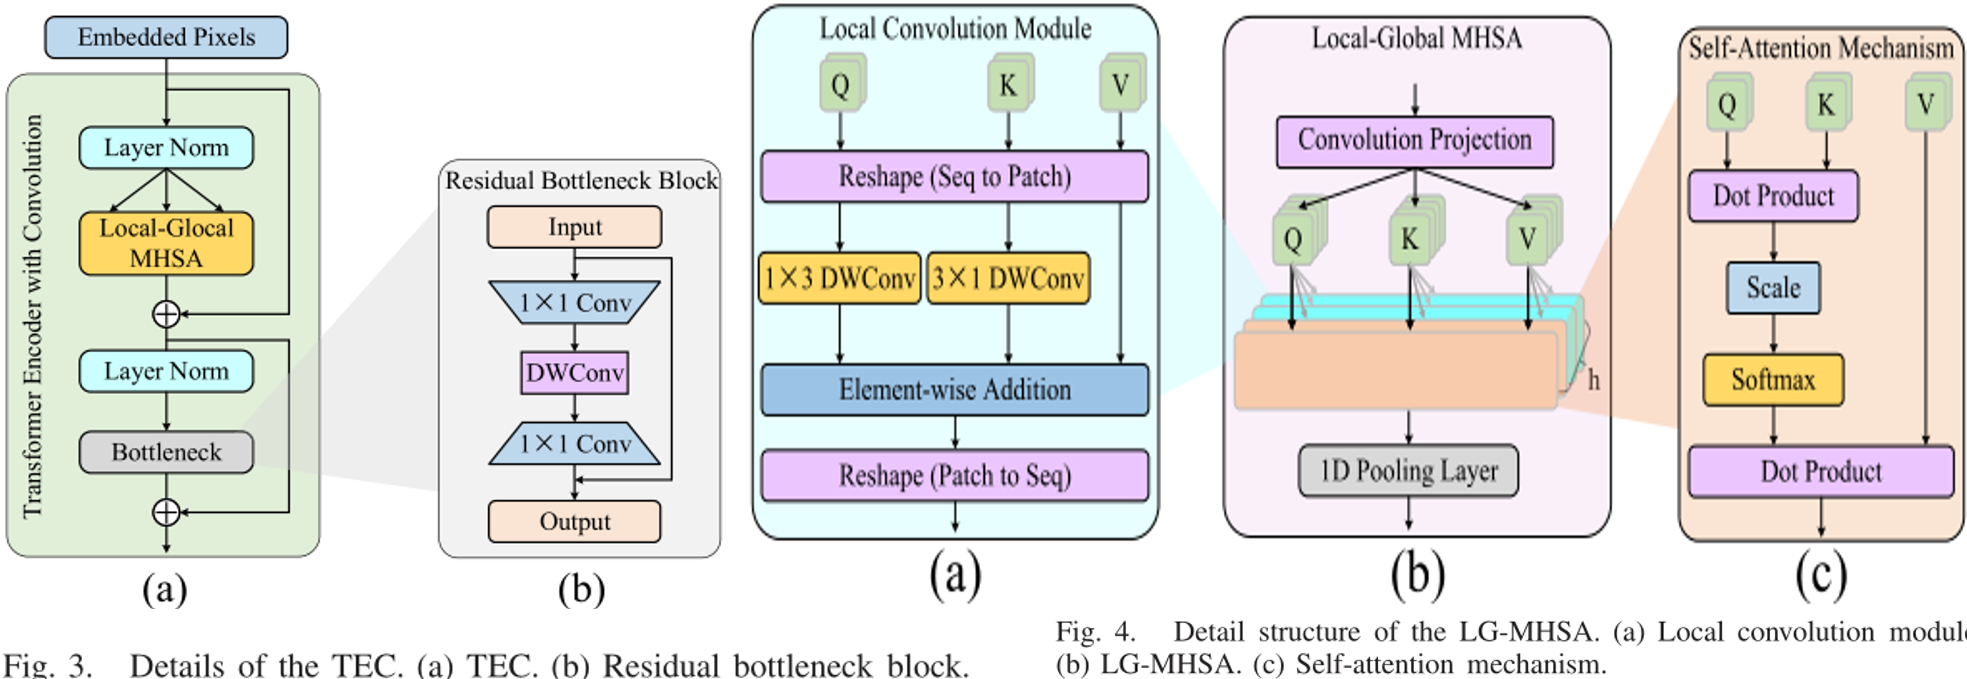

In [9]:
class Attention_Conv(nn.Module):#LG-MSH模块操作，其输入数据是pos_embedding之后的数据
  def __init__(self,  dim:int, head_dim:int, num_heads:int, num_patch:int, patch_size:int):
    super().__init__()
    #print("Transformer第一步：LG-MSH模块操作开始，其输入数据是pos_embedding之后的数据")
    self.dim = dim
    self.head_dim = head_dim
    self.num_patch = num_patch
    self.patch_size = patch_size
    self.num_heads = num_heads
    self.inner_dim = head_dim * num_heads
    self.scale = head_dim ** -0.5
    self.atten = nn.Softmax(dim=-1)
    self.act = nn.ReLU(inplace=True)
    self.bn = nn.BatchNorm2d(dim)
    self.qkv = nn.Conv2d(dim, self.inner_dim * 3, kernel_size=1, padding=0, groups=dim, bias=False)
    self.avgpool=nn.AdaptiveAvgPool1d(dim)
    self.qs = nn.Conv2d(dim, dim, kernel_size=(1, 3), padding=(0, 1), groups=dim, bias=False)#Fig4--(a)
    self.ks = nn.Conv2d(dim, dim, kernel_size=(3, 1), padding=(1, 0), groups=dim, bias=False)#Fig4--(a)
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    b, n, d = x.shape
    x = x.contiguous().view(b, self.dim, self.num_patch, self.num_patch)

    qkv = self.qkv(F.relu(self.bn(x)))
    qkv = qkv.contiguous().view(b, self.num_patch*self.num_patch, self.inner_dim * 3)
    qkv = qkv.chunk(3, dim=-1)
    q, k, v = map(lambda t: einops.rearrange(t, "b n (h d) -> b h n d", h=self.num_heads), qkv)#得到QKV

    q_1 = q[:, 0:self.num_heads//2, :, :]
    k_1 = k[:, 0:self.num_heads//2, :, :]
    v_1 = v[:, 0:self.num_heads//2, :, :]
    q_2 = q[:, self.num_heads//2:self.num_heads, :, :].reshape(b, -1, int(math.sqrt(n)), int(math.sqrt(n)))
    k_2 = k[:, self.num_heads//2:self.num_heads, :, :].reshape(b, -1, int(math.sqrt(n)), int(math.sqrt(n)))
    v_2 = v[:, self.num_heads//2:self.num_heads, :, :].reshape(b, -1, int(math.sqrt(n)), int(math.sqrt(n)))
    q_2 = self.qs(q_2)#Fig4--(a)
    k_2 = self.ks(k_2)#Fig4--(a)
    res_2 = (q_2 + k_2 + v_2).reshape(b, n, -1)

    scores = torch.einsum("b h i d, b h j d -> b h i j", q_1, k_1)
    scores = scores * self.scale
    attn = self.atten(scores)
    out = torch.einsum("b h i j, b h j d -> b h i d", attn, v_1)
    out = einops.rearrange(out, "b h n d -> b n (h d)")
    res = torch.cat([out, res_2], axis=2)
    out = self.avgpool(res)
    #print("#LG-MSH模块操作处理后的x.shape为：",out.shape)
    return out
class FeedForward_Conv(nn.Module):#上面第一张图片中的b图，即RNN操作
  def __init__(self, dim: int, hidden_dim: int, num_patch: int, patch_size: int):
    super().__init__()
    #print("Transformer第二步：FF模块操作开始，其输入数据是LG-MSH模块操作处理后的数据")
    self.dim = dim
    self.num_patch = num_patch
    self.patch_size = patch_size
    self.conv1 = nn.Sequential(
        nn.BatchNorm2d(dim), nn.GELU(), 
        nn.Conv2d(dim, 64, kernel_size=1, padding=0, bias=False)
    )
    self.conv2 = nn.Sequential(
        nn.BatchNorm2d(64), nn.GELU(),
        nn.Conv2d(64, 64, kernel_size=3, padding=1, groups=64, bias=False) 
    )
    self.conv3 = nn.Sequential(
        nn.BatchNorm2d(64), nn.GELU(),
        nn.Conv2d(64, dim, kernel_size=1, padding=0, bias=False)
    )
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    b, hw, dim = x.shape     # [bs, num_seq, dim]
    x_reshape = x.contiguous().view(b, self.dim, self.num_patch, self.num_patch)
    out1 = self.conv1(x_reshape)
    out2 = self.conv2(out1)
    out3 = self.conv3(out2) + x_reshape
    result = out3.contiguous().view(b, self.num_patch * self.num_patch, self.dim)
    #print("FF块操作处理后的x.shape为：",result.shape)
    return result
class transformer(nn.Module):
  def __init__(self, dim: int, num_layers: int, num_heads: int, head_dim: int, hidden_dim: int, num_patch: int, patch_size: int):
    super().__init__()
    #print("Transformer第三步：Transformer模块操作开始，其输入数据是LG-MSH模块和FF模块操作处理后的数据")
    self.layers = nn.ModuleList()
    for _ in range(num_layers):
      layer = [
           nn.Sequential(nn.LayerNorm(dim), Attention_Conv(dim, head_dim, num_heads, num_patch, patch_size)),
           nn.Sequential(nn.LayerNorm(dim), FeedForward_Conv(dim, hidden_dim, num_patch, patch_size))       
      ]
      self.layers.append(nn.ModuleList(layer))
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    for attn, ff in self.layers:
       x = attn(x) + x
       x = ff(x) + x
    #print("Transformer块操作处理后的x.shape为：",x.shape)
    return x

In [10]:
# 随机输入，测试网络结构是否通
x = torch.randn(size=(1, 1, 100, 11, 11))
net = CTMixer(channels=100, num_classes=9, image_size=11, datasetname='IP', num_layers=1, num_heads=4)
y = net(x)
print(y.shape)
#summary(net, input_size=(1, 1, 100, 11, 11), device="cpu")

torch.Size([1, 9])


**加载数据**

In [11]:
!pip install spectral

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 212 kB 34.4 MB/s 


In [12]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
import spectral
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import copy

In [13]:
# 对高光谱数据 X 应用 PCA 变换
def applyPCA(X, numComponents):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0], X.shape[1], numComponents))
    return newX

# 对单个像素周围提取 patch 时，边缘像素就无法取了，因此，给这部分像素进行 padding 操作
#在矩阵外围创建两圈0
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

# 在每个像素周围提取 patch ，然后创建成符合 keras 处理的格式
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    # 给 X 做 padding
    margin = int((windowSize - 1) / 2)
    #print(margin)
    #print(X.shape)
    zeroPaddedX = padWithZeros(X, margin=margin)#在X周围生成两圈0
    #print("zeroPaddedX.shape",zeroPaddedX.shape)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))#生成0矩阵，形状为.......
    #print("patchesData.shape:",patchesData.shape)
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))#生成0矩阵，现状为一维
    #print("patchesLabels.shape:",patchesLabels.shape)
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]
            #print("patch.shape为：",patch.shape)   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    #print("patchData.shape:",patchesData.shape)
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState, stratify=y)
    return X_train, X_test, y_train, y_test

In [15]:
# 地物类别
class_num = 16
X = sio.loadmat('/content/drive/MyDrive/AI data/hyperspetral image/Indian_pines_corrected.mat')['indian_pines_corrected']
y = sio.loadmat('/content/drive/MyDrive/AI data/hyperspetral image/Indian_pines_gt.mat')['indian_pines_gt']

# 用于测试样本的比例
test_ratio = 0.90
# 每个像素周围提取 patch 的尺寸
patch_size = 11
# 使用 PCA 降维，得到主成分的数量
pca_components = 100

print('Hyperspectral data shape: ', X.shape)
print('Label shape: ', y.shape)

print('\n... ... PCA tranformation ... ...')
X_pca = applyPCA(X, numComponents=pca_components)
print('Data shape after PCA: ', X_pca.shape)

print('\n... ... create data cubes ... ...')
X_pca, y = createImageCubes(X_pca, y, windowSize=patch_size)
print('Data cube X shape: ', X_pca.shape)
print('Data cube y shape: ', y.shape)

print('\n... ... create train & test data ... ...')
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X_pca, y, test_ratio)
print('Xtrain shape: ', Xtrain.shape)
print('Xtest  shape: ', Xtest.shape)

# 改变 Xtrain, Ytrain 的形状，以符合 keras 的要求
Xtrain = Xtrain.reshape(-1, patch_size, patch_size, pca_components, 1)
Xtest  = Xtest.reshape(-1, patch_size, patch_size, pca_components, 1)
print('before transpose: Xtrain shape: ', Xtrain.shape) 
print('before transpose: Xtest  shape: ', Xtest.shape) 

# 为了适应 pytorch 结构，数据要做 transpose
Xtrain = Xtrain.transpose(0, 4, 3, 1, 2)
Xtest  = Xtest.transpose(0, 4, 3, 1, 2)
print('after transpose: Xtrain shape: ', Xtrain.shape) 
print('after transpose: Xtest  shape: ', Xtest.shape) 

Hyperspectral data shape:  (145, 145, 200)
Label shape:  (145, 145)

... ... PCA tranformation ... ...
Data shape after PCA:  (145, 145, 100)

... ... create data cubes ... ...
Data cube X shape:  (10249, 11, 11, 100)
Data cube y shape:  (10249,)

... ... create train & test data ... ...
Xtrain shape:  (1024, 11, 11, 100)
Xtest  shape:  (9225, 11, 11, 100)
before transpose: Xtrain shape:  (1024, 11, 11, 100, 1)
before transpose: Xtest  shape:  (9225, 11, 11, 100, 1)
after transpose: Xtrain shape:  (1024, 1, 100, 11, 11)
after transpose: Xtest  shape:  (9225, 1, 100, 11, 11)


In [16]:
""" Training dataset"""
class TrainDS(torch.utils.data.Dataset): 
    def __init__(self):
        self.len = Xtrain.shape[0]
        self.x_data = torch.FloatTensor(Xtrain)
        self.y_data = torch.LongTensor(ytrain)        
    def __getitem__(self, index):
        # 根据索引返回数据和对应的标签
        return self.x_data[index], self.y_data[index]
    def __len__(self): 
        # 返回文件数据的数目
        return self.len

""" Testing dataset"""
class TestDS(torch.utils.data.Dataset): 
    def __init__(self):
        self.len = Xtest.shape[0]
        self.x_data = torch.FloatTensor(Xtest)
        self.y_data = torch.LongTensor(ytest)
    def __getitem__(self, index):
        # 根据索引返回数据和对应的标签
        return self.x_data[index], self.y_data[index]
    def __len__(self): 
        # 返回文件数据的数目
        return self.len

# 创建 trainloader 和 testloader
trainset = TrainDS()
testset  = TestDS()
train_loader = torch.utils.data.DataLoader(dataset=trainset, batch_size=128, shuffle=True, num_workers=2)
test_loader  = torch.utils.data.DataLoader(dataset=testset,  batch_size=128, shuffle=False, num_workers=2)

In [17]:
def train(net):


  current_loss_his = []
  current_Acc_his = []

  best_net_wts = copy.deepcopy(net.state_dict())
  best_acc = 0.0

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(net.parameters(), lr=0.001)

  # 开始训练
  total_loss = 0
  for epoch in range(100):
      net.train()  # 将模型设置为训练模式
      for i, (inputs, labels) in enumerate(train_loader):
          inputs = inputs.to(device)
          labels = labels.to(device)
          # 优化器梯度归零
          optimizer.zero_grad()
          # 正向传播 +　反向传播 + 优化 
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          total_loss += loss.item()

      net.eval()   # 将模型设置为验证模式
      current_acc = test_acc(net)
      current_Acc_his.append(current_acc)

      if current_acc > best_acc:
        best_acc = current_acc
        best_net_wts = copy.deepcopy(net.state_dict())

      print('[Epoch: %d]   [loss avg: %.4f]   [current loss: %.4f]  [current acc: %.4f]' %(epoch + 1, total_loss/(epoch+1), loss.item(), current_acc))
      current_loss_his.append(loss.item())

  print('Finished Training')
  print("Best Acc:%.4f" %(best_acc))

  # load best model weights
  net.load_state_dict(best_net_wts)

  return net,current_loss_his,current_Acc_his

In [18]:
def test_acc(net):
  count = 0
  # 模型测试
  for inputs, _ in test_loader:
      inputs = inputs.to(device)
      outputs = net(inputs)
      outputs = np.argmax(outputs.detach().cpu().numpy(), axis=1)
      if count == 0:
          y_pred_test =  outputs
          count = 1
      else:
          y_pred_test = np.concatenate( (y_pred_test, outputs) )

  # 生成分类报告
  classification = classification_report(ytest, y_pred_test, digits=4)
  index_acc = classification.find('weighted avg')
  accuracy = classification[index_acc+17:index_acc+23]
  return float(accuracy)

In [19]:
# 使用GPU训练，可以在菜单 "代码执行工具" -> "更改运行时类型" 里进行设置
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 网络放到GPU上
net = CTMixer(channels=100, num_classes=16, image_size=11, datasetname='IP', num_layers=1, num_heads=4).to(device)
# 训练
net,current_loss_his,current_Acc_his = train(net)

[Epoch: 1]   [loss avg: 13.3739]   [current loss: 1.1572]  [current acc: 0.7067]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Epoch: 2]   [loss avg: 9.2009]   [current loss: 0.4028]  [current acc: 0.8939]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Epoch: 3]   [loss avg: 6.8854]   [current loss: 0.1963]  [current acc: 0.9414]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Epoch: 4]   [loss avg: 5.5144]   [current loss: 0.1611]  [current acc: 0.9432]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Epoch: 5]   [loss avg: 4.5732]   [current loss: 0.0823]  [current acc: 0.9649]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Epoch: 6]   [loss avg: 3.9005]   [current loss: 0.0889]  [current acc: 0.9813]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Epoch: 7]   [loss avg: 3.4017]   [current loss: 0.0424]  [current acc: 0.9776]
[Epoch: 8]   [loss avg: 3.0147]   [current loss: 0.0365]  [current acc: 0.9847]
[Epoch: 9]   [loss avg: 2.7052]   [current loss: 0.0285]  [current acc: 0.9881]
[Epoch: 10]   [loss avg: 2.4532]   [current loss: 0.0233]  [current acc: 0.9892]
[Epoch: 11]   [loss avg: 2.2442]   [current loss: 0.0244]  [current acc: 0.9912]
[Epoch: 12]   [loss avg: 2.0685]   [current loss: 0.0142]  [current acc: 0.9913]
[Epoch: 13]   [loss avg: 1.9179]   [current loss: 0.0110]  [current acc: 0.9887]
[Epoch: 14]   [loss avg: 1.7888]   [current loss: 0.0138]  [current acc: 0.9903]
[Epoch: 15]   [loss avg: 1.6755]   [current loss: 0.0161]  [current acc: 0.9908]
[Epoch: 16]   [loss avg: 1.5755]   [current loss: 0.0089]  [current acc: 0.9910]
[Epoch: 17]   [loss avg: 1.4871]   [current loss: 0.0073]  [current acc: 0.9900]
[Epoch: 18]   [loss avg: 1.4081]   [current loss: 0.0089]  [current acc: 0.9907]
[Epoch: 19]   [loss avg: 1.3369

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
def show_plot(data,plot_name,x_name,y_name):
  plt.title(plot_name)
  plt.xlabel(x_name)
  plt.ylabel(y_name)
  plt.plot(data)

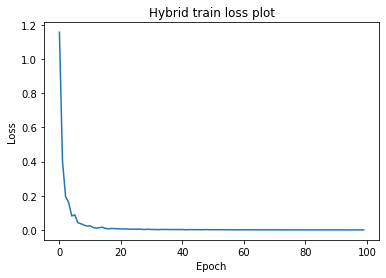

In [21]:
show_plot(current_loss_his,'Hybrid train loss plot','Epoch','Loss')

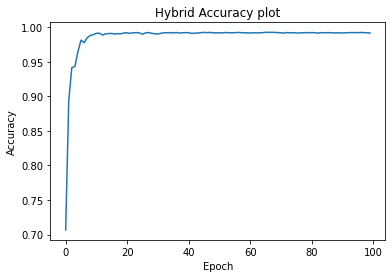

In [22]:
show_plot(current_Acc_his,'Hybrid Accuracy plot','Epoch','Accuracy')

In [23]:
net.eval()   # 将模型设置为验证模式
# 测试最好的模型的结果
count = 0
# 模型测试
for inputs, _ in test_loader:
    inputs = inputs.to(device)
    outputs = net(inputs)
    outputs = np.argmax(outputs.detach().cpu().numpy(), axis=1)
    if count == 0:
        y_pred_test =  outputs
        count = 1
    else:
        y_pred_test = np.concatenate( (y_pred_test, outputs) )

# 生成分类报告
classification = classification_report(ytest, y_pred_test, digits=4)
print(classification)

              precision    recall  f1-score   support

         0.0     1.0000    1.0000    1.0000        41
         1.0     0.9984    0.9728    0.9854      1285
         2.0     0.9920    1.0000    0.9960       747
         3.0     1.0000    1.0000    1.0000       213
         4.0     0.9977    1.0000    0.9989       435
         5.0     0.9954    0.9954    0.9954       657
         6.0     1.0000    1.0000    1.0000        25
         7.0     1.0000    1.0000    1.0000       430
         8.0     1.0000    0.8889    0.9412        18
         9.0     0.9943    0.9909    0.9926       875
        10.0     0.9844    0.9973    0.9908      2210
        11.0     0.9924    0.9831    0.9878       534
        12.0     1.0000    1.0000    1.0000       185
        13.0     0.9965    1.0000    0.9982      1139
        14.0     0.9886    0.9971    0.9928       347
        15.0     0.9524    0.9524    0.9524        84

    accuracy                         0.9926      9225
   macro avg     0.9933   

In [24]:
# load the original image
X = sio.loadmat('/content/drive/MyDrive/AI data/hyperspetral image/Indian_pines_corrected.mat')['indian_pines_corrected']
y = sio.loadmat('/content/drive/MyDrive/AI data/hyperspetral image/Indian_pines_gt.mat')['indian_pines_gt']

height = y.shape[0]
width = y.shape[1]

X = applyPCA(X, numComponents= pca_components)
X = padWithZeros(X, patch_size//2)

# 逐像素预测类别
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        if int(y[i,j]) == 0:
            continue
        else :
            image_patch = X[i:i+patch_size, j:j+patch_size, :]
            image_patch = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1)
            X_test_image = torch.FloatTensor(image_patch.transpose(0, 4, 3, 1, 2)).to(device)                                   
            prediction = net(X_test_image)
            prediction = np.argmax(prediction.detach().cpu().numpy(), axis=1)
            outputs[i][j] = prediction+1
    if i % 20 == 0:
        print('... ... row ', i, ' handling ... ...')

... ... row  0  handling ... ...
... ... row  20  handling ... ...
... ... row  40  handling ... ...
... ... row  60  handling ... ...
... ... row  80  handling ... ...
... ... row  100  handling ... ...
... ... row  120  handling ... ...
... ... row  140  handling ... ...


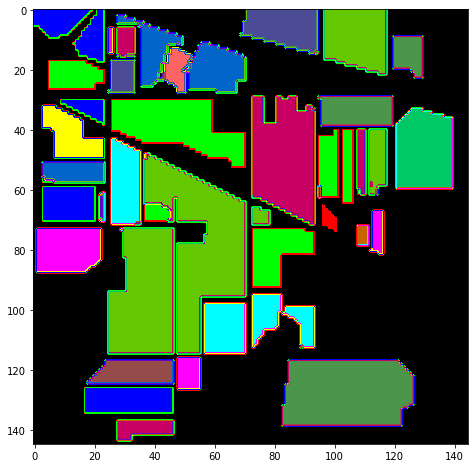

In [26]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(8,8))